In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.io.wavfile import read
device = 'cpu'

In [18]:
# functions used in the whole lab
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

def display_spectrum(sound_array, sampling_rate=44100):
  """ Display magnitude spectrum of signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # compute the spectrum of the windowed input signal
  spectrum = fft(sound_array)
  # compute the magnitude spectrum in dB
  magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))

  # plot the magnitude spectrum
  plt.figure(0, figsize=(10, 5))
  plt.plot(magnitude_spectrum)
  plt.ylabel('amplitude (dB)')
  plt.show()

def signal2pytorch(x):
    # Function to convert a signal vector x into a 3-d Tensor that conv1d of Pytorch expects
    return torch.from_numpy(x).reshape(1,1,-1)


In [20]:
# Define the model architecture
class Convautoenc(nn.Module):
    def __init__(self):
        super(Convautoenc, self).__init__()
        
        # Analysis filter bank (encoder):
        # - Convolutional layer with a kernel size of 2048 and a stride of 1024, providing downsampling by 1024.
        # - Input has 1 channel (e.g., single audio channel) and output has 64 channels.
        # - Padding of 1023 ensures 'same' output size with respect to stride, so the output maintains useful spatial information.
        # - This layer learns 64 filters to extract features from the input signal.
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=2048, stride=1024, padding=1023, bias=True)

        # Synthesis filter bank (decoder):
        # - Transposed convolutional layer with kernel size 2048 and stride 1024, acting as the "inverse" of the encoder.
        # - Input has 64 channels (from the encoder) and output has 1 channel, reconstructing the signal back to its original channel dimension.
        # - Padding of 1023 aligns the output size to match the input shape, ensuring symmetry in the encoder-decoder structure.
        self.t_conv1 = nn.ConvTranspose1d(in_channels=64, out_channels=1, kernel_size=2048, stride=1024, padding=1023, bias=True)

    def encoder(self, x):
        # Encoder pass (analysis step):
        # - Applies the convolutional layer defined in __init__ (self.conv1) on input x.
        # - Uses ReLU activation to introduce non-linearity, allowing the model to learn complex patterns.
        z = F.relu(self.conv1(x))
        return z  # Encoded features (latent representation)

    def decoder(self, z):
        # Decoder pass (synthesis step):
        # - Applies the transposed convolutional layer (self.t_conv1) on the encoded features z.
        # - This step reconstructs the original input from its compressed latent representation.
        x = self.t_conv1(z)
        return x  # Reconstructed signal

    def forward(self, x):
        # Complete forward pass of the autoencoder:
        # - First encodes the input to obtain latent representation z.
        z = self.encoder(x)
        # - Then decodes z to reconstruct the output y.
        y = self.decoder(z)
        return y  # Final output, reconstructed signal


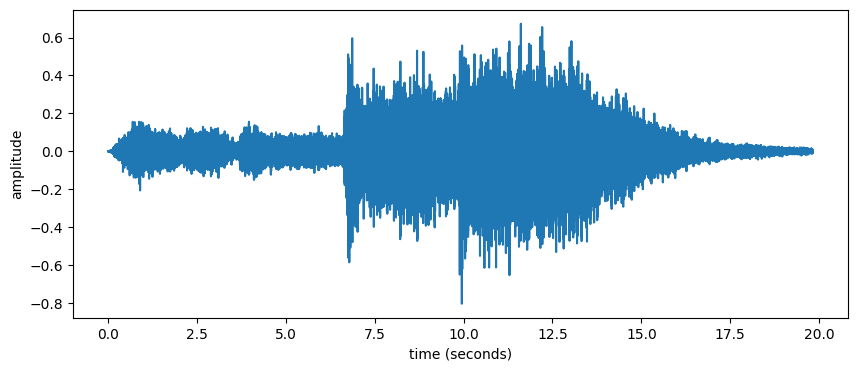

In [21]:
# Read training data

# set the batch size for training
batch=1

# load the audio file
audio1, samplerate = read_sound("../sounds/162095-chinese-orchestra-channel-1.wav")

# convert the audio signal to PyTorch format
X_train = signal2pytorch(audio1).to(device)

# display training sound
display_sound(audio1, samplerate)

In [22]:
# Train model 

# create instance of model
model = Convautoenc().to(device)
print('Total number of parameters: %i' % (sum(p.numel() for p in model.parameters() if p.requires_grad)))
# loss function used is Mean Square Error
loss_fn = nn.MSELoss()
# generate initial predictions for the training data
Ypred = model(X_train)
#length of the signal at the output of the network
outputlen = len(Ypred[0,0,:])
print("outputlen=", outputlen)
#the target signal with same length as model output
Y=X_train[:,:,:outputlen]

# define the size of each update step and initialize the optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train the model over a number of epochs
nepochs = 500
for epoch in range(nepochs):
  # generates predictions for the current epoch
  Ypred = model(X_train)
  # computes the error between the predicted output and the target output
  loss = loss_fn(Ypred, Y)
  # prints the loss every 50 epochs
  if epoch%50==0:
    print(f"Epoch [{epoch}/{nepochs}], Loss: {loss.item():.4f}")
  # Resets the gradients of all model parameters to zero before backpropagation
  optimizer.zero_grad()
  # Computes gradients of the loss with respect to model parameters via backpropagation
  loss.backward()
  # Updates model parameters based on gradients calculated
  optimizer.step()

Total number of parameters: 262209
outputlen= 873474
Epoch [0/500], Loss: 0.0102
Epoch [50/500], Loss: 0.0020
Epoch [100/500], Loss: 0.0010
Epoch [150/500], Loss: 0.0006
Epoch [200/500], Loss: 0.0005
Epoch [250/500], Loss: 0.0004
Epoch [300/500], Loss: 0.0004
Epoch [350/500], Loss: 0.0003
Epoch [400/500], Loss: 0.0003
Epoch [450/500], Loss: 0.0003


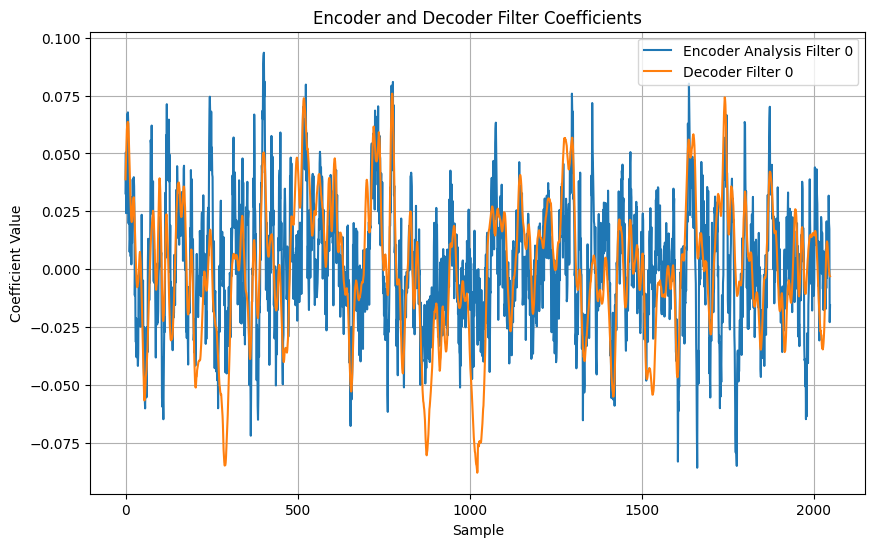

Number of input signal values: 874006
Number of elements in encoded signal: 54656


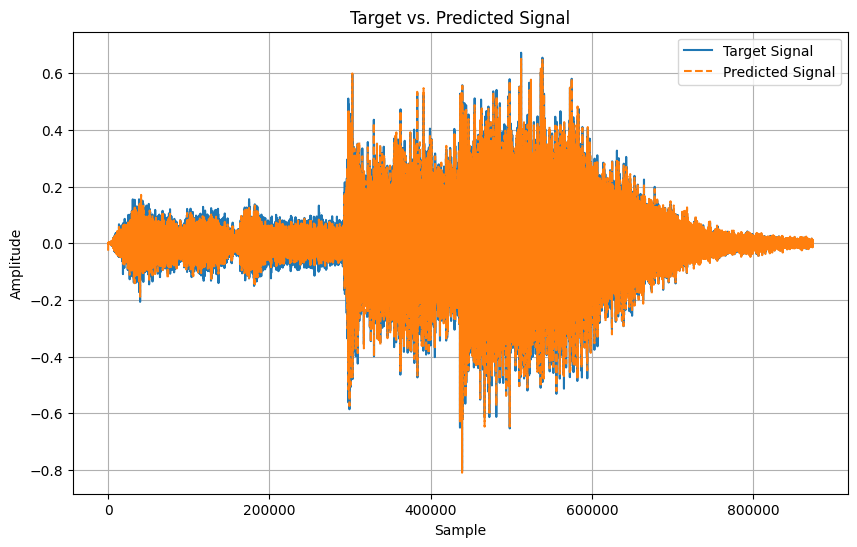

In [23]:
# Make model predictions using the training data

# Read and extract model weights
weights = model.state_dict()

# Convert the weights directly to NumPy arrays and transpose for plotting
encoder_weights = weights['conv1.weight'][0, 0, :].numpy().T
decoder_weights = weights['t_conv1.weight'][0, 0, :].numpy().T

# Plot obtained weights for encoder and decoder
plt.figure(figsize=(10, 6))
plt.plot(encoder_weights, label='Encoder Analysis Filter 0')
plt.plot(decoder_weights, label='Decoder Filter 0')
plt.xlabel('Sample')
plt.ylabel('Coefficient Value')
plt.title('Encoder and Decoder Filter Coefficients')
plt.legend()
plt.grid()
plt.show()

# Encode and decode to get predictions
encoded_signal = model.encoder(X_train)
print(f"Number of input signal values: {X_train.numel()}")
print(f"Number of elements in encoded signal: {encoded_signal.numel()}")

predictions = model.decoder(encoded_signal).detach().cpu().numpy()  # Convert to NumPy after detaching
target = Y.cpu().numpy()  # Convert target to NumPy for plotting

# Plot target signal and model predictions for comparison
plt.figure(figsize=(10, 6))
plt.plot(target[0, 0, :], label='Target Signal')
plt.plot(predictions[0, 0, :], label='Predicted Signal', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Target vs. Predicted Signal')
plt.legend()
plt.grid()
plt.show()

# Prepare reconstructed signal for playback (remove unnecessary dimensions)
reconstructed_signal = predictions[0, 0, :]

In [24]:
# play input and predicted sounds
display(ipd.Audio(audio1, rate=samplerate))
display(ipd.Audio(reconstructed_signal, rate=samplerate))

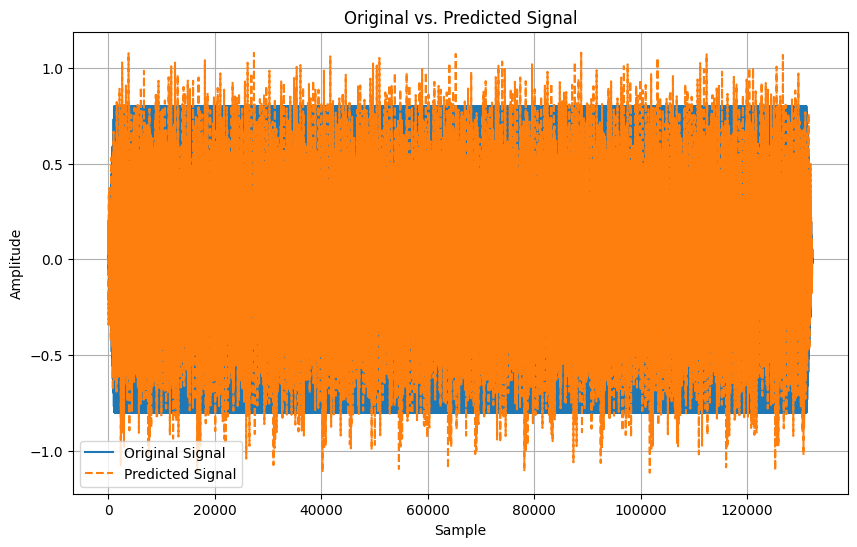

In [25]:
# Encode/decode on signal different from the one used for training

# audio2, samplerate = read_sound("../sounds/162095-chinese-orchestra-channel-2.wav")
audio2, samplerate = read_sound("../sounds/sinewave.wav")
#Convert to pytorch format, batch is first dimension
X_test = signal2pytorch(audio2).to(device) 

# Make Predictions based on the obtained weights
predictions = model(X_test).detach().cpu().numpy()  # Ensure predictions are detached and on CPU

# Plot the original test signal and the model's predicted reconstruction
plt.figure(figsize=(10, 6))
plt.plot(X_test[0, 0, :].detach().cpu().numpy(), label='Original Signal')  # Original test signal, detached
plt.plot(predictions[0, 0, :], label='Predicted Signal', linestyle='--')  # Model prediction
plt.legend()
plt.title('Original vs. Predicted Signal')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid()
plt.show()

# Prepare reconstructed signal for playback (remove unnecessary dimensions)
reconstructed_signal = predictions[0, 0, :]


In [ ]:
# play input and predicted sound
display(ipd.Audio(audio2, rate=samplerate))
display(ipd.Audio(reconstructed_signal, rate=samplerate))